In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import os
import requests
from zipfile import ZipFile

## Read in Data
Source: https://www.cdc.gov/nchs/nhis/2022nhis.htm

In [2]:
filename = 'adult22'
url = f'https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/NHIS/2022/{filename}csv.zip'

response = requests.get(url)

with open('temp.zip', 'wb') as file:
    file.write(response.content)

zf = ZipFile('temp.zip')
zf.extractall()
zf.close()

nhis = pd.read_csv(f'{filename}.csv')

os.remove('temp.zip')
os.remove('readme.txt')
os.remove(f'{filename}.csv')

print(f'Shape - {nhis.shape}\n-----\n')

nhis.head()

Shape - (27651, 637)
-----



,URBRRL,RATCAT_A,INCTCFLG_A,IMPINCFLG_A,SHOTTYPE1_A,CEVOTELC_A,CEMMETNG_A,CEVOLUN2_A,CEVOLUN1_A,HITTEST_A,...,PROXYREL_A,PROXY_A,AVAIL_A,HHSTAT_A,INTV_MON,RECTYPE,IMPNUM_A,WTFA_A,HHX,POVRATTC_A
0,2,7,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,10,1,4548.583,H059086,1.92
1,4,14,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,10,1,7087.431,H054049,10.30
2,4,14,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,10,1,8125.516,H055201,9.36
3,4,11,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,1,1,10,1,7837.390,H044893,3.66
4,1,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,3,1,1,10,1,10234.356,H043149,0.69


## Correlation between Income and Food Security

---- Frequency Measures ----


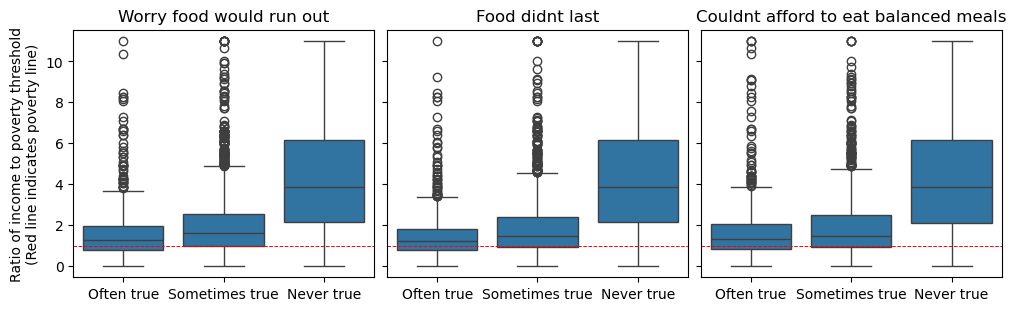

---- Binary Measures ----


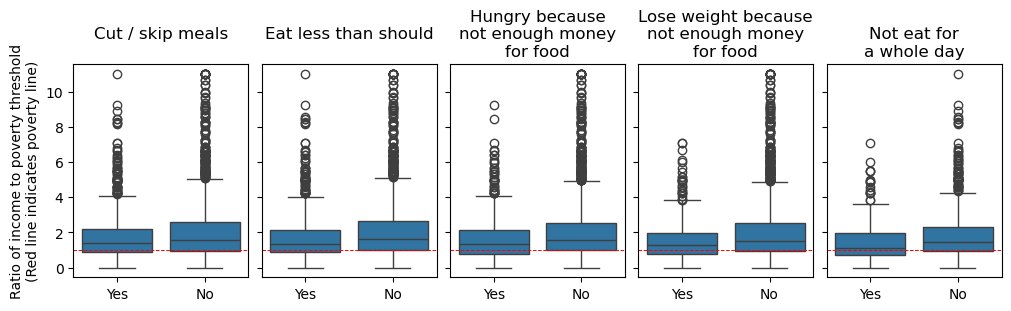

---- Custom Food Security Scores ----


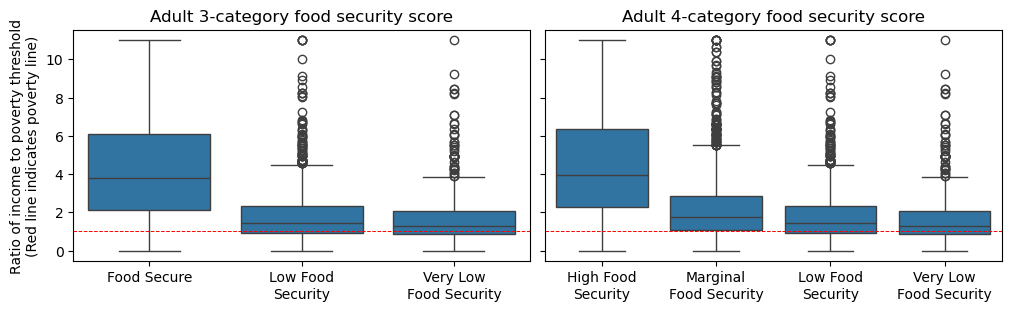

---- Numeric Measures ----


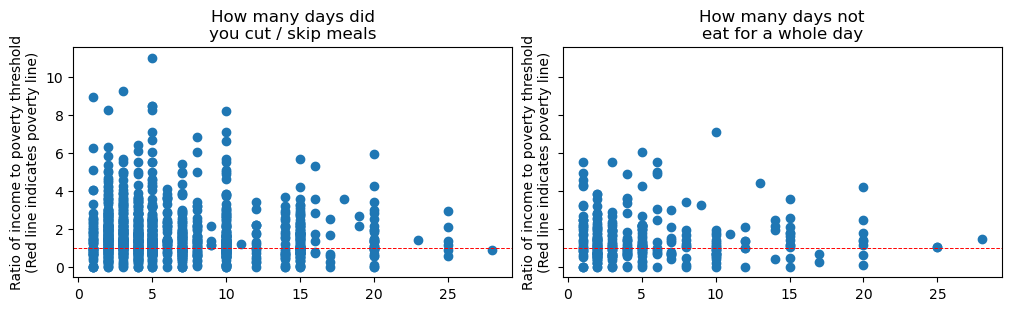

In [7]:
variable_to_title = {
    'Frequency Measures': {
        'FDSRUNOUT_A': 'Worry food would run out',
        'FDSLAST_A': 'Food didnt last',
        'FDSBALANCE_A': 'Couldnt afford to eat balanced meals'
    },
    'Binary Measures': {
        'FDSSKIP_A': '\nCut / skip meals\n',
        'FDSLESS_A': '\nEat less than should\n',
        'FDSHUNGRY_A': 'Hungry because\nnot enough money\nfor food',
        'FDSWEIGHT_A': 'Lose weight because\nnot enough money\nfor food',
        'FDSNOTEAT_A': 'Not eat for\na whole day'
    },
    'Custom Food Security Scores': {
        'FDSCAT3_A': 'Adult 3-category food security score',
        'FDSCAT4_A': 'Adult 4-category food security score'
    },
    'Numeric Measures': {
        'FDSSKIPDYS_A': 'How many days did\nyou cut / skip meals',
        'FDSNEDAYS_A': 'How many days not\neat for a whole day',
        # 'POVRATTC_A': 'Ratio of income\nto poverty level'
    }
}

response_code_to_string = {
    'Frequency Measures': {
        1: 'Often true', 
        2: 'Sometimes true',
        3: 'Never true',
    },
    'Binary Measures': {
        1: 'Yes',
        2: 'No',
    },
    'FDSCAT3_A': {
        1: 'Food Secure',
        2: 'Low Food\nSecurity',
        3: 'Very Low\nFood Security'
    },
    'FDSCAT4_A': {
        1: 'High Food\nSecurity',
        2: 'Marginal\nFood Security',
        3: 'Low Food\nSecurity',
        4: 'Very Low\nFood Security'
    }
}

for var_type in variable_to_title:

    print(f'---- {var_type} ----')
    num_vars = len(variable_to_title[var_type])

    fig, axes = plt.subplots(1, num_vars, figsize=(10, 3), sharey=True, layout='constrained')

    for ax, col in zip(axes.ravel(), variable_to_title[var_type].keys()):
        if var_type == 'Numeric Measures':
            max_value = 29
            plot_df = nhis[nhis[col] <= max_value]
            ax.scatter(x=col, y='POVRATTC_A', data=plot_df)
        elif var_type == 'Custom Food Security Scores':
            max_value = 4
            plot_df = nhis[nhis[col] <= max_value]
            sns.boxplot(x=col, y='POVRATTC_A', data=plot_df, ax=ax)
            locs = ax.get_xticks()
            ax.set_xticks(locs, [response_code_to_string[col].get(int(loc+1), '') for loc in locs])
        else:
            max_value = max(response_code_to_string[var_type].keys())
            plot_df = nhis[nhis[col] <= max_value]
            sns.boxplot(x=col, y='POVRATTC_A', data=plot_df, ax=ax)
            locs = ax.get_xticks()
            ax.set_xticks(locs, [response_code_to_string[var_type].get(int(loc+1), '') for loc in locs])

        ax.set_title(variable_to_title[var_type][col])
        ax.set_ylabel('Ratio of income to poverty threshold\n(Red line indicates poverty line)')
        ax.set_xlabel('')

        ax.axhline(y=1, color='r', linestyle='--', linewidth=0.7)

    plt.show()

The above visualizations provide strong evidence of the correlation between income and food security. Specifically, as income decreases, food security worsens.  
We see this trend persist across multiple measures. The above visualizations consider a variety of survey questions. In every case, we see individuals with lower income experience situations consistent with food insecurity:
1. They worry about having sufficient funds to buy food.
2. They more frequently skip meals, go hungry, or lose weight.
3. In the NHIS's aggregate measures, the mean income for individuals with lower food security is consistently lower.

## Comparisons by Sex and Age

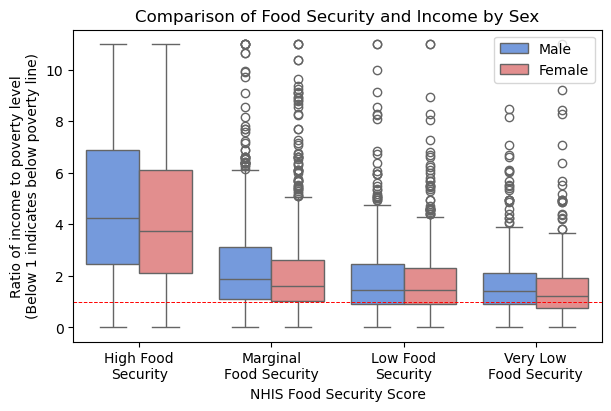

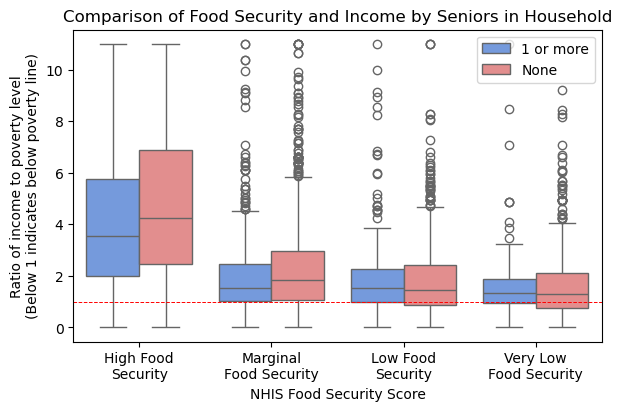

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, layout='constrained')

plot_df = nhis[(nhis['FDSCAT4_A'] <= 4) & (nhis['SEX_A'] <= 2)]
plot_df.loc[:, 'SEX_A'] = plot_df['SEX_A'].map({1: 'Male', 2: 'Female'})
sns.boxplot(x='FDSCAT4_A', y='POVRATTC_A', hue='SEX_A', data=plot_df, ax=ax, palette=['cornflowerblue', 'lightcoral'])

locs = ax.get_xticks()
ax.set_xticks(locs, [response_code_to_string['FDSCAT4_A'].get(int(loc+1), '') for loc in locs])

ax.set_title('Comparison of Food Security and Income by Sex')
ax.set_ylabel('Ratio of income to poverty level\n(Below 1 indicates below poverty line)')
ax.set_xlabel('NHIS Food Security Score')

ax.axhline(y=1, color='r', linestyle='--', linewidth=0.7)

ax.legend(loc='upper right')

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, layout='constrained')

plot_df = nhis[(nhis['FDSCAT4_A'] <= 4) & (nhis['OVER65FLG_A'] <= 2)]
plot_df.loc[:, 'OVER65FLG_A'] = plot_df['OVER65FLG_A'].map({0: 'None', 1: '1 or more'})
sns.boxplot(x='FDSCAT4_A', y='POVRATTC_A', hue='OVER65FLG_A', data=plot_df, ax=ax, palette=['cornflowerblue', 'lightcoral'])

locs = ax.get_xticks()
ax.set_xticks(locs, [response_code_to_string['FDSCAT4_A'].get(int(loc+1), '') for loc in locs])

ax.set_title('Comparison of Food Security and Income by Seniors in Household')
ax.set_ylabel('Ratio of income to poverty level\n(Below 1 indicates below poverty line)')
ax.set_xlabel('NHIS Food Security Score')

ax.axhline(y=1, color='r', linestyle='--', linewidth=0.7)

ax.legend(loc='upper right')

plt.show()

In comparing (i) men and women and (ii) households who live with an individual 65+ and those who don't, we find clear differences in terms of income. Men and individuals who do not live with a senior both tend to have higher incomes. The distribution of these groups across food security categories, however, does not appear dramatically different.

## Comparisons by Region, Children, Education and Race

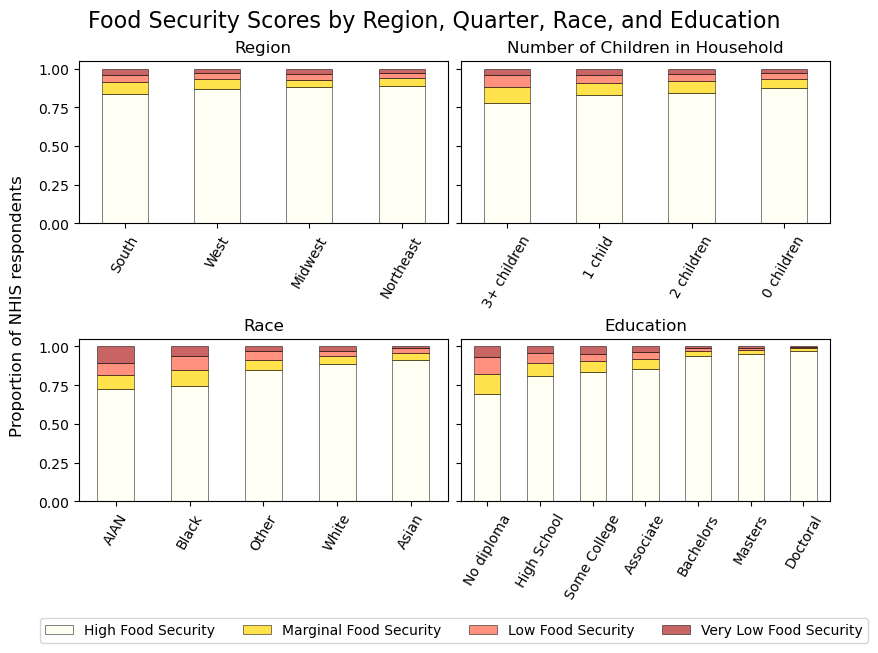

In [11]:
variables_dict = {
    'REGION': ['Region', 4, {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}],
    'PCNTLT18TC': ['Number of Children in Household', 3, {0: '0 children', 1: '1 child', 2: '2 children', 3: '3+ children'}],
    'RACEALLP_A': ['Race', 6, {
        1: 'White',
        2: 'Black',
        3: 'Asian',
        4: 'AIAN',
        # 5: 'AIAN',
        6: 'Other',
        7: 'Refused',
        8: 'Not Ascertained',
        9: 'Dont know'
    }],
    'EDUCP_A': ['Education', 10, {
        # 0: 'Never attended',
        # 1: 'Grade 1-11',
        2: 'No diploma',
        # 3: 'GED',
        4: 'High School',
        5: 'Some College',
        6: 'Associate',
        # 7: 'Associate',
        8: 'Bachelors',
        9: 'Masters',
        10: 'Doctoral',
        97: 'Refused',
        98: 'Not Ascertained',
        99: 'Dont Know'
    }],
    'FDSCAT4_A': ['Food Security', 4, {
        1: 'High Food Security',
        2: 'Marginal Food Security',
        3: 'Low Food Security',
        4: 'Very Low Food Security'
    }]
}

nhis.RACEALLP_A = nhis.RACEALLP_A.apply(lambda x: 4 if x == 5 else x)
nhis.EDUCP_A = nhis.EDUCP_A.apply(lambda x: 2 if x == 0 else 2 if x == 1 else 4 if x == 3 else 6 if x == 7 else x)

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharey=True, layout='constrained')
colors = ['ivory', 'gold', 'tomato', 'firebrick']

for var, ax, i in zip(variables_dict.keys(), axes.flatten(), range(4)):
    plot_df = nhis[(nhis['FDSCAT4_A'] <= 4) & (nhis[var] <= variables_dict[var][1])]
    count_data = plot_df.groupby([var, 'FDSCAT4_A']).size().unstack(fill_value=0)
    normalized_data = count_data.div(count_data.sum(axis=1), axis=0).sort_values(by=1)
    
    normalized_data.plot(
          kind='bar', stacked=True, ax=ax, legend=False, 
          color=colors, edgecolor='black', linewidth=0.5, alpha=0.7
    )

    ax.set_title(variables_dict[var][0])
    ax.set_xlabel('')
    locs = ax.get_xticks()
    codes = [int(label.get_text()) for label in ax.get_xticklabels()]
    labels = [variables_dict[var][2][code] for code in codes]
    ax.set_xticks(locs, labels, rotation=60)

handles, labels = [], []
for handle, label in zip(*ax.get_legend_handles_labels()):
        handles.append(handle)
        labels.append(variables_dict['FDSCAT4_A'][2][int(label)])
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.525, -0.075))

fig.text(-0.03, 0.5, 'Proportion of NHIS respondents', va='center', rotation='vertical', fontsize=12)
fig.suptitle('Food Security Scores by Region, Quarter, Race, and Education', fontsize=16)

plt.show()

These comparisons reveal several insights. Most importantly, food security does *not* appear evenly distributed across certain sections of the population.  
1. Households with 3 or more children experience higher levels of insecurity than those with no children. In general, the presence of children appears to increase the incidence of insecurity.
2. Non-white respondents tended to indicate higher levels of food insecurity (excluding those of Asian descent, which appeared comparable to white respondents). AIAN (which refers to American Indian and Alaskan Native) and Black respondents showed much higher rates of insecurity.
3. Food security appears clearly correlated with level of education, with more educated individuals showing high levels of security.
4. Regional disparities appear, but they are much less drastic than those that appear across other socio-economic markers.